In [19]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#### Categorias do Documento  
Como explicado na documentação, os textos são divididos em algumas categorias. Para processar os dados, deve-se converter essas strings em números.  
É importante lembrar que antes de executar o programa deve-se descompactar o arquivo *rcv1rcv2aminigoutte.tar.gz* na pasta do projeto. Isso criará a pasta *rcv1rcv2aminigoutte*, que contém os arquivos necessários para o problema.

In [20]:
categories = {'C15': 4587, 'CCAT': 8745, 'E21': 9625, 'ECAT': 5656, 'GCAT': 5745, 'M11': 45845}

Esse método faz esse tratamento dos dados, substituindo as strings correspondentes as classes em seus respectivos números.

In [21]:
def filter_datas(file, target_file):
    with open(file, 'r') as document_read:
        with open(target_file, 'w') as document_write:
            for line in document_read:
                target = line.split(None, 1)[0]
                line_to_write = '%s %s' % (categories[target], line[len(target)+1:len(line)])
                document_write.write(line_to_write)
        
    return target_file

#### Carregando o dataset no formato SVMLight

In [22]:
file = filter_datas('rcv1rcv2aminigoutte/EN/Index_EN-EN', 'svml_en_en.txt')
X,  y = load_svmlight_file(file)

#### Aplicando a seleção das features

In [23]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

In [24]:
print('Data matrix shape before feature selection: ' + str(X.shape))
print('Data matrix shape after feature selection: ' + str(X_new.shape))

Data matrix shape before feature selection: (18758, 21531)
Data matrix shape after feature selection: (18758, 3001)


#### Dividindo o dataset
O método *train_test_split* é bem útil para dividir os dados em partes que serão usados para o treino do modelo e os testes, que serão convenientes para avaliar o modelo. Os dados de treino estarão em *x_train* e *y_train*, e os dados de teste em *x_test* e *y_test*, sendo que 25% dos dados serão usados para os testes e os outros 75% para o treinamento.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

#### Encontrando um bom k
Um dos parâmetros mais importantes no algoritmo do *KNeighborsClassifier* é o *k*, que significa quantos "vizinhos" mais próximos serão considerados para classificar um dado de teste. Por exemplo, se *k = 3*, serão analizadas as três classes vizinhas mais próximos, sendo que aquela que for mais comum irá classificar esse dado.

In [26]:
k_scores = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    knn_score = knn.score(X_test, y_test)
    print('Score for k = ' + str(k) + ': ' + str(knn_score))
    
    k_scores.append(knn_score)

Score for k = 1: 0.6023454157782516
Score for k = 2: 0.5646055437100214
Score for k = 3: 0.5285714285714286
Score for k = 4: 0.5279317697228145
Score for k = 5: 0.5106609808102346
Score for k = 6: 0.5142857142857142
Score for k = 7: 0.506183368869936
Score for k = 8: 0.5221748400852878
Score for k = 9: 0.5336886993603411
Score for k = 10: 0.5353944562899787


Para encontrar um bom *k*, foram feitos 10 testes, com *k* variando de 1 até 10. O modelo é testado a cada iteração e a acurácia é aferida. O maior resultado desses testes é um forte candidato para a escolha do *k*.

In [27]:
np_k_scores = np.asarray(k_scores)
best_k = np.argmax(np_k_scores) + 1
print('Best k to KNN Classifier: ' + str(best_k))

Best k to KNN Classifier: 1


### Avaliando o modelo
O modelo é criado utilizando o *k* que foi encontrado acima.  
Os dados de treino são usados para treinar o modelo através do método *fit*, enquanto os dados de teste são usados no método *predict* para testar o modelo.

In [28]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

#### Matriz de confusão
A matriz de confusão nos mostra os números de observações previstas em um grupo conhecido *i*, mas que foram previstos em um grupo *j*, ou seja, relaciona os valores reais com os previstos pelo classificador.

In [29]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
class_as_number = [4587, 8745, 9625, 5656, 5745, 45845]
confusion = confusion_matrix(y_test, y_pred, labels=class_as_number)

In [31]:
i = 0
for c in y_pred:
    if c == 5745:
        i += 1

print(i)

2884


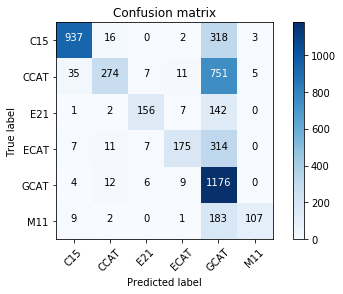

In [32]:
class_as_string = ['C15', 'CCAT', 'E21', 'ECAT', 'GCAT', 'M11']

plt.figure() 
plot_confusion_matrix(confusion, classes=class_as_string)

plt.show()

#### Relatório de classificação

In [33]:
report = classification_report(y_test, y_pred, labels=class_as_number, target_names=class_as_string)
print(report)

             precision    recall  f1-score   support

        C15       0.94      0.73      0.83      1276
       CCAT       0.86      0.25      0.39      1083
        E21       0.89      0.51      0.64       308
       ECAT       0.85      0.34      0.49       514
       GCAT       0.41      0.97      0.57      1207
        M11       0.93      0.35      0.51       302

avg / total       0.77      0.60      0.59      4690

